### Load the dataset

In [36]:
!pip install -q -U einops datasets matplotlib tqdm


In [37]:
from torch import nn
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np
from torch.optim import Adam

In [38]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [39]:
class UpBlockWithCopy(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1
        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        layers = [
            nn.ConvTranspose2d(2*in_ch, out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((skip, x), 1)
        return self.model(x)

In [40]:
# Time embeddings
class EmbedNosieTimestamp(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim),
            nn.Unflatten(1, (output_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, time):
        time=time.view(-1, self.input_dim)
        return self.model(time)

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()


True

In [42]:
import torch
import torchvision
from torchvision.transforms import Resize, Compose, ToTensor, Lambda, ToPILImage

import math
from inspect import isfunction
from functools import partial
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

BATCH_SIZE=128

def convertTensorToImage(img):
    reverse_transform = Compose([
        Lambda(lambda x: (x*2)+1),
        Lambda(lambda x: x*255),
        ToPILImage()
    ])

    return reverse_transform(img)

def convertImage(x):
    return (x*2)-1

def load_dataset_with_transform(image_size):
    data_transforms = Compose([
        Resize((image_size, image_size)),
        ToTensor(),
        convertImage
    ])

    dataset = torchvision.datasets.MNIST('./data/', transform=data_transforms, download=True)

    data_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=0)
    return data_loader

data = load_dataset_with_transform(28)

def visualize_conv_2d(sample, show_images=False):
    print("\nSample dimensions = ", sample.shape,)
    if show_images:
      plt.figure(figsize=(8,8))
      for c in range(len(sample)):
          print(c, sample[c].shape)
          cols =4
          rows = len(sample) // cols
          plt.subplot(rows+1,cols+1, c+1)
          plt.imshow(sample[c])


In [43]:
class UNetModel(nn.Module):
    def __init__(self, debug=False) -> None:
        super().__init__()
        down_sampling = [16, 32, 64]
        up_sampling = [64, 32, 16]
        self.debug = debug
        n_input_channels = 1
        latent_image_size = 7

        self.init_block = nn.Sequential(
            nn.Conv2d(n_input_channels, down_sampling[0], 3, padding=1),
            nn.BatchNorm2d(down_sampling[0]),
            nn.ReLU()
        )

        self.down1 = DownBlock(down_sampling[0], down_sampling[1])
        self.down2 = DownBlock(down_sampling[1], down_sampling[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_sampling[2]*latent_image_size**2, down_sampling[1]),
            nn.ReLU(),
            nn.Linear(down_sampling[1], down_sampling[1]),
            nn.ReLU(),
            nn.Linear(down_sampling[1], down_sampling[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.time_embedding1 = EmbedNosieTimestamp(1, up_sampling[0])
        self.time_embedding2 = EmbedNosieTimestamp(1, up_sampling[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_sampling[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_sampling[0], up_sampling[0], 3, padding=1),
            nn.BatchNorm2d(up_sampling[0]),
            nn.ReLU(),
        )

        self.up1 = UpBlockWithCopy(up_sampling[0], up_sampling[1])
        self.up2 = UpBlockWithCopy(up_sampling[1], up_sampling[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_sampling[-1], up_sampling[-1], 3, 1, 1),
            nn.BatchNorm2d(up_sampling[-1]),
            nn.ReLU(),
            nn.Conv2d(up_sampling[-1], n_input_channels, 3, 1, 1),
        )

    def forward(self, x, t):
        # print ("Running forward with image shape : ", x.shape)
        x = self.init_block(x)

        down1 = self.down1(x)
        down2 = self.down2(down1)
        x = self.to_vec(down2)

        x = self.dense_emb(x)
        tembed1 = self.time_embedding1(t.to(torch.float))
        tembed2 = self.time_embedding2(t.to(torch.float))

        x = self.up0(x)+tembed1
        up1 = self.up1(x, down2)+tembed2
        up2 = self.up2(up1, down1)
        out = self.out(up2)

        return out

model = UNetModel(debug=False).to(device)

print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  377665


### Loss function for noise
Inorder to predict noise, we can MSE mechanism to find the loss between original image and when noise is added.

In the example below, an image is taken and noise is added to it at various timesteps.

The loss function calcualtes the image data loss with the original and its increase as in the curve

In [44]:
# image at certain step directly
input = Image.open("/content/ace_of_clubs.png")
input = ToTensor()(input)
beta = torch.linspace(0.0001, 0.02, 150).to(device)
iters = len(beta)
alpha = 1. - beta
alpha_cumu_prod = torch.cumprod(alpha, dim=0)
sqrt_a_bar = torch.sqrt(alpha_cumu_prod).to(device)  # Mean Coefficient
sqrt_one_minus_a_bar = torch.sqrt(1 - alpha_cumu_prod).to(device) # St. Dev. Coefficient

def getImageAtIter(iters, input):
    t = iters
    noise = torch.randn_like(input).to(device)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]
    # print (sqrt_a_bar_t.shape, input.shape, sqrt_one_minus_a_bar_t.shape, noise.shape)
    x_t = sqrt_a_bar_t * input + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

def loss_fun(a,b):
    return torch.nn.MSELoss()(a,b)

# losses = [loss_fun(getImageAtIter(i, input)[1], input) for i in range(10)]

# plt.plot(losses)


The loss function can be used along with adam optimizer ar lr=0.0001 to learn about the loss.

In [45]:
optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 10

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(data):
        optimizer.zero_grad()

        images = batch[0].to(device)
        t = torch.randint(0, iters, (len(images),), dtype=torch.long, device=device)
        loss_added, noise = getImageAtIter(t, images)
        lossy_images = model(loss_added, t).to(device)
        loss = loss_fun(lossy_images, images)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} Loss: {loss.item()} ")


Epoch 0 | Step 000 Loss: 1.1414159536361694 
Epoch 0 | Step 100 Loss: 0.1883072704076767 
Epoch 0 | Step 200 Loss: 0.08064490556716919 
Epoch 0 | Step 300 Loss: 0.06772225350141525 
Epoch 0 | Step 400 Loss: 0.05461720749735832 
Epoch 1 | Step 000 Loss: 0.05558888614177704 
Epoch 1 | Step 100 Loss: 0.053706664592027664 
Epoch 1 | Step 200 Loss: 0.04974237084388733 
Epoch 1 | Step 300 Loss: 0.046882789582014084 
Epoch 1 | Step 400 Loss: 0.048235971480607986 
Epoch 2 | Step 000 Loss: 0.04257655888795853 
Epoch 2 | Step 100 Loss: 0.051593467593193054 
Epoch 2 | Step 200 Loss: 0.04263083636760712 
Epoch 2 | Step 300 Loss: 0.04145612567663193 
Epoch 2 | Step 400 Loss: 0.04179682582616806 
Epoch 3 | Step 000 Loss: 0.04210483282804489 
Epoch 3 | Step 100 Loss: 0.036955468356609344 
Epoch 3 | Step 200 Loss: 0.034931015223264694 
Epoch 3 | Step 300 Loss: 0.036562081426382065 
Epoch 3 | Step 400 Loss: 0.03395221754908562 
Epoch 4 | Step 000 Loss: 0.038215912878513336 
Epoch 4 | Step 100 Loss: 0.0

In [58]:
sqrt_a_inv = torch.sqrt(1 / alpha)
pred_noise_coeff = (1 - alpha) / torch.sqrt(1 - alpha_cumu_prod)

@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = beta[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

In [59]:
T=150
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))
@torch.no_grad()
def sample_images(ncols, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = T / ncols

    # Noise to generate images from
    x_t = torch.randn((1, 1, 28, 28), device=device)

    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            ax.axis('off')
            show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

<ipython-input-59-ba0a840cc193>:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, ncols+1, plot_number)


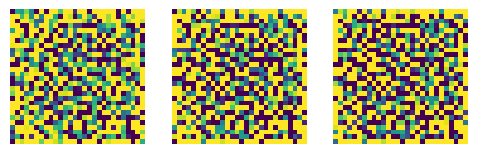

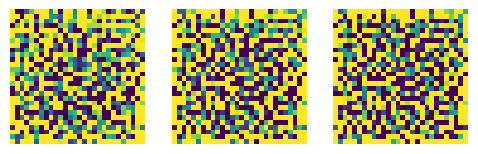

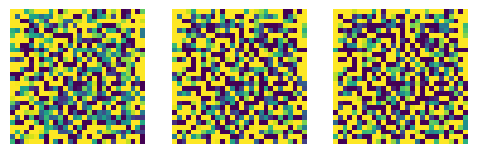

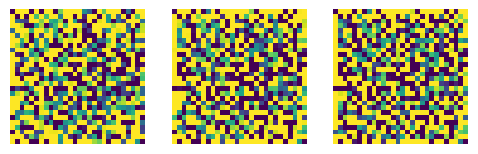

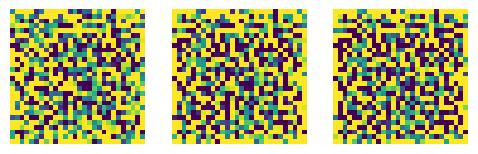

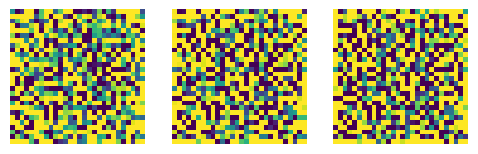

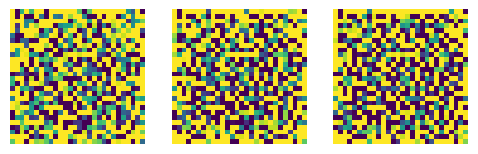

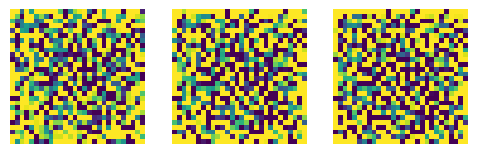

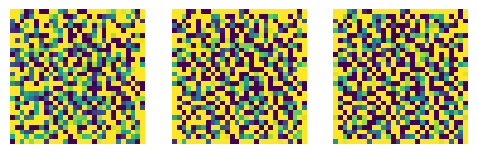

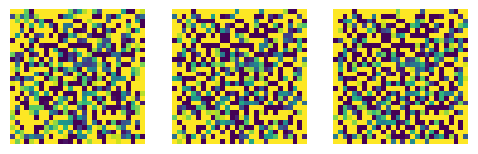

In [60]:
model.eval()
figsize=(8,8) # Change me
ncols = 3 # Should evenly divide T
for _ in range(10):
    sample_images(ncols, figsize=figsize)